# **Imports**🎇

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm
import os
import json
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

import torch
from torch.utils.data import DataLoader, random_split, Dataset
import torch.optim as optim

import torchvision
from torchvision import transforms as T
from torchvision.utils import make_grid
from torchvision.transforms import functional as F


In [3]:
print(torch.cuda.get_device_properties(0))

_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40)


# **Utils**

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

n_epoch = 50

# **Prepare Labels and Files**

In [ ]:
!labelme

In [ ]:
# for folder in ['train', 'valid', 'test']:
#     for file in os.listdir(os.path.join(folder, 'photo/')):
#         filename = file.split('.')[0]+'.json'
#         existing_filepath = os.path.join('labels', filename)
#         if os.path.exists(existing_filepath):
#             new_filepath = os.path.join(folder, 'label', filename)
#             os.replace(existing_filepath, new_filepath)


# **Functions**

In [5]:
class TrumpDataset(Dataset):
    def __init__(self, phase, root=''):
        self.phase = phase

        self.images_list = []
        self.labels = []
        for item in os.listdir(os.path.join(root, phase, 'photo')):
            img_path = os.path.join(root, phase, 'photo', item)
            self.images_list.append(img_path)
            self.labels.append(os.path.join(root, phase, 'label', '.'.join(item.split('.')[:-1]) + '.json'))


    def __getitem__(self, item):
        img_path = os.path.join(self.images_list[item])
        img = Image.open(img_path).convert('RGB')
        img = F.to_tensor(img)

        with open(self.labels[item]) as f:
            load = json.load(f)
            points = []
            for i in range(len(load['shapes'])):
                points.append(
                    [load['shapes'][i]['points'][1][0],
                     load['shapes'][i]['points'][0][1],
                     load['shapes'][i]['points'][0][0],
                     load['shapes'][i]['points'][1][1]])

        boxes = torch.tensor(points, dtype=torch.float32)
        labels = torch.ones((len(load['shapes']), ), dtype=torch.int64)
        #
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        #
        return img, target

    def __len__(self):
        return len(self.images_list)

In [24]:
import math
def train_one_epoch(model, optimizer, train_loader, epoch=None):
    model.train()
    total_loss = 0
    with tqdm(train_loader, unit="batch") as tepoch:
        for images, targets in tepoch:
            if epoch is not None:
                tepoch.set_description(f"Epoch {epoch}")
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            total_loss += losses
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
    return total_loss/len(train_loader)

In [77]:
def evaluate(model, test_dataloader):
    model.eval()
    with torch.no_grad():
        cnt = 0
        for images , targets in test_dataloader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            out = model(images)
            scores = out[0]['scores'].cpu().numpy()
            inds = scores > 0.95
            bxs = out[0]['boxes'].cpu().numpy()
            bxs = bxs[inds]
            gt = targets[0]['boxes'].cpu().numpy()
            # gt = gt[0]
            img = images[0].permute(1, 2, 0).cpu().numpy()
            #----------------------------------------------------------
            fig, ax = plt.subplots(1)
            ax.imshow(img)
            for j in range(len(gt)):
                rect1 = patches.Rectangle((int(gt[j][0]),int(gt[j][1])),abs(gt[j][0]-gt[j][2]),
                                abs(gt[j][1]-gt[j][3]),linewidth=3,edgecolor='g',facecolor='none')
                ax.add_patch(rect1)
            for i in range(len(bxs)):
                rect = patches.Rectangle((int(bxs[i][0]),int(bxs[i][1])),abs(bxs[i][0]-bxs[i][2]),
                                        abs(bxs[i][1]-bxs[i][3]),linewidth=3,edgecolor='r',facecolor='none',)
                ax.add_patch(rect)
                rx, ry = rect.get_xy()
                cx = rx + rect.get_width()
                cy = ry + rect.get_height()/10.
                ax.annotate(scores[i], (cx, cy), color='white', weight='bold', fontsize=10, ha='center', va='center', backgroundcolor='red')

            fig.savefig(f"/content/output_images/{cnt}.png".format(cnt), dpi=90, bbox_inches='tight')
            cnt = cnt + 1

# **Dataloader**⚽

In [46]:
train = TrumpDataset(root='/content/drive/MyDrive/', phase='train')
test = TrumpDataset(root='/content/drive/MyDrive/', phase='test')

In [47]:
def new_concat(batch):
  return tuple(zip(*batch))

In [48]:
train_loader = DataLoader(train,
                            batch_size=2,
                            shuffle=True,
                            collate_fn=new_concat)
test_loader = DataLoader(test,
                            batch_size=1,
                            shuffle=True,
                            collate_fn=new_concat)


# **Model**🎯

In [49]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(1024, 2)
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [50]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

# **Train**🎢

In [59]:
num_epochs = 10

for epoch in range(num_epochs):
    loss = train_one_epoch(model, optimizer, train_loader)
    print('epoch [{}]:  \t lr: {}  \t loss: {}  '.format(epoch, lr_scheduler.get_last_lr(), loss))
    lr_scheduler.step()

100%|██████████| 59/59 [00:35<00:00,  1.68batch/s]


epoch [0]:  	 lr: [5e-06]  	 loss: 0.03861448913812637  


100%|██████████| 59/59 [00:36<00:00,  1.63batch/s]


epoch [1]:  	 lr: [5e-06]  	 loss: 0.03877021372318268  


100%|██████████| 59/59 [00:35<00:00,  1.66batch/s]


epoch [2]:  	 lr: [5.000000000000001e-07]  	 loss: 0.03806774318218231  


100%|██████████| 59/59 [00:35<00:00,  1.64batch/s]


epoch [3]:  	 lr: [5.000000000000001e-07]  	 loss: 0.03820795193314552  


100%|██████████| 59/59 [00:35<00:00,  1.65batch/s]


epoch [4]:  	 lr: [5.000000000000001e-07]  	 loss: 0.038512472063302994  


100%|██████████| 59/59 [00:36<00:00,  1.63batch/s]


epoch [5]:  	 lr: [5.000000000000001e-08]  	 loss: 0.03886648267507553  


100%|██████████| 59/59 [00:35<00:00,  1.66batch/s]


epoch [6]:  	 lr: [5.000000000000001e-08]  	 loss: 0.038742344826459885  


100%|██████████| 59/59 [00:35<00:00,  1.66batch/s]


epoch [7]:  	 lr: [5.000000000000001e-08]  	 loss: 0.03814307227730751  


100%|██████████| 59/59 [00:36<00:00,  1.63batch/s]


epoch [8]:  	 lr: [5.000000000000002e-09]  	 loss: 0.03848028555512428  


100%|██████████| 59/59 [00:35<00:00,  1.68batch/s]

epoch [9]:  	 lr: [5.000000000000002e-09]  	 loss: 0.03882703185081482  


# **Evaluate**

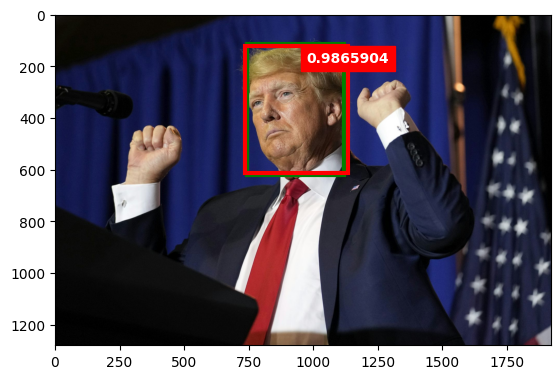

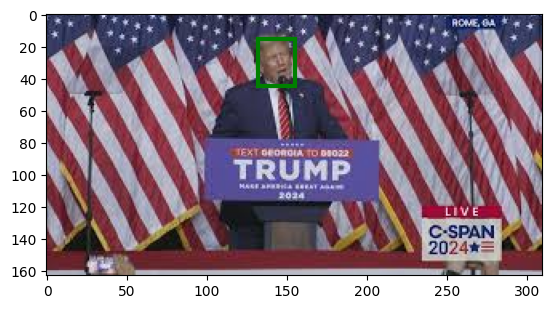

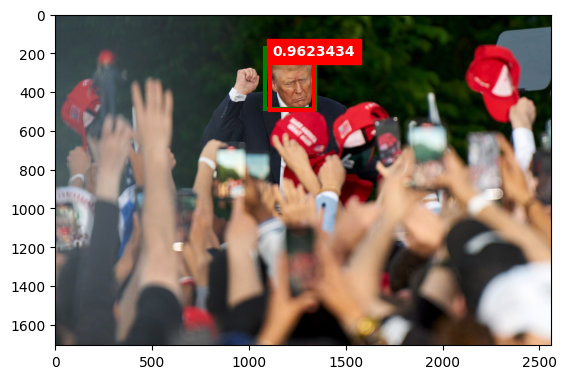

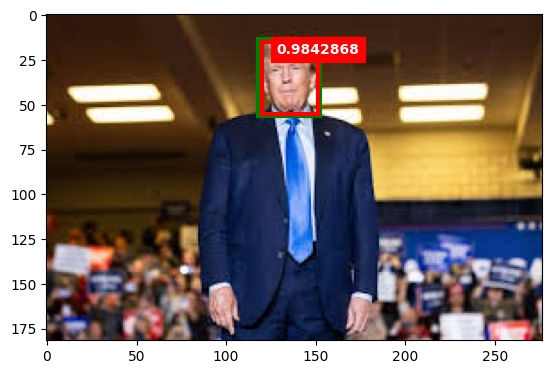

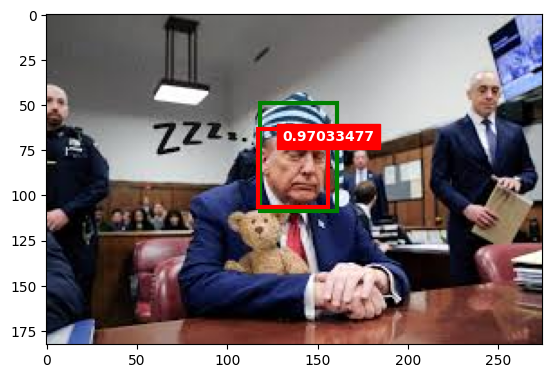

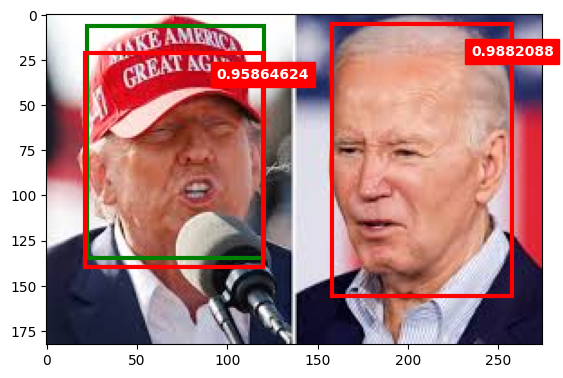

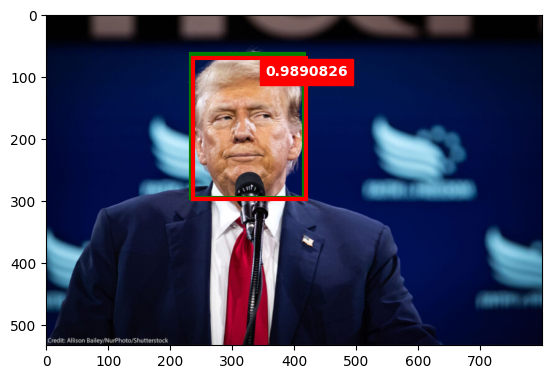

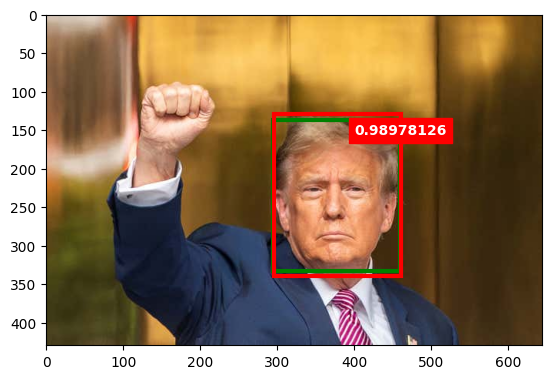

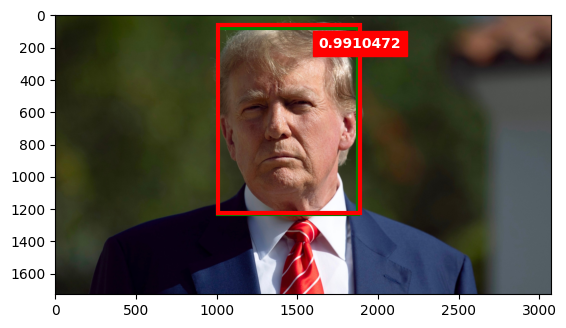

In [78]:
evaluate(model, test_loader)